In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from math import sqrt
from scipy.stats import norm
from scipy.stats import uniform
import cmath #for complex numbers
from scipy.integrate import quad #for numerical integration
from sklearn.preprocessing import MinMaxScaler
import scipy


In [168]:
#input:
#output: Call option price with strike K and Maturity T
def heston_closed(a,b,c,T,K,rho,V0,S0,r=0):
    
    def char_f(w,a,b,c,T,K,rho,V0,S0,r):
        alpha = -0.5*w*(w+complex(0,1))
        beta = a - rho*c*w*complex(0,1)
        gamma = c*c/2
        h = cmath.sqrt(beta*beta-4*alpha*gamma)
        rplus = (beta + h)/c/c
        rminus = (beta - h)/c/c
        g = rminus/rplus
        D =  rminus*(1-cmath.exp(-h*T))/(1-g*cmath.exp(-h*T))
        C = a*(rminus*T-2/c/c*cmath.log((1-g*cmath.exp(-h*T))/(1-g)))
        return cmath.exp(C*b+D*V0+complex(0,1)*w*cmath.log(S0*cmath.exp(r*T)))

    def integrand1(w):
        i = complex(0,1)
        return (cmath.exp(-i*w*cmath.log(K))*char_f(w-i,a,b,c,T,K,rho,V0,S0,r)/i/w/char_f(-i,a,b,c,T,K,rho,V0,S0,r)).real
    
    def integrand2(w):
        i = complex(0,1)
        return (cmath.exp(-i*w*cmath.log(K))*char_f(w,a,b,c,T,K,rho,V0,S0,r)/i/w).real
    
    pi1 = 0.5 + quad(integrand1,0,np.inf)[0]/np.pi
    pi2 = 0.5 + quad(integrand2,0,np.inf)[0]/np.pi
    
    return (S0*pi1 + cmath.exp(-r*T)*K*pi2).real

In [296]:
num_input_parameters = 6
num_output_parameters = 1
learning_rate = 0.1
num_steps = 2000
batch_size = 20
num_neurons = 6

scaler = MinMaxScaler()

X = tf.placeholder(tf.float32, [None, num_input_parameters])
y = tf.placeholder(tf.float32, [None, num_output_parameters])

In [297]:
#input: X,y,batch_size
#output: X_batch,y_batch: randomly chosen rows from X,y 
def next_batch_heston_train(batch_size,X=None,y=None):
    #for heston X contains values for a,b,c,rho,T,K and S0,V0 are kept fixed for now
    X = np.zeros((batch_size,num_input_parameters))
    y = np.zeros((batch_size,num_output_parameters))
    
    X[:,0] = 2*uniform.rvs(size=batch_size)+1 #a
    X[:,1] = 2*uniform.rvs(size=batch_size)+1 #b
    X[:,2] = uniform.rvs(size=batch_size) #c
    X[:,3] = uniform.rvs(size=batch_size) #rho
    X[:,4] = 10*uniform.rvs(size=batch_size)+1 #maturities T 
    X[:,5] = uniform.rvs(size=batch_size)+0.5 #strikes K
    S0 = 1
    V0 = 1
    
    for i in range(batch_size):
        y[i,0] = heston_closed(X[i,0],X[i,1],X[i,2],X[i,4],X[i,5],X[i,3],V0,S0)
    
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)
    
    return X,y

In [298]:
#Layers
hidden1 = fully_connected(X, num_neurons, activation_fn=tf.nn.elu)
hidden2 = fully_connected(hidden1, num_neurons, activation_fn=tf.nn.elu)
hidden3 = fully_connected(hidden2, num_neurons, activation_fn=tf.nn.elu)
hidden4 = fully_connected(hidden3, num_neurons, activation_fn=tf.nn.elu)

outputs = fully_connected(hidden4, num_output_parameters, activation_fn=None)

In [299]:
#Loss Function
loss = tf.reduce_mean(tf.sqrt(tf.square(outputs - y)))  # MSE

In [300]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [301]:
init = tf.global_variables_initializer()

In [302]:
saver = tf.train.Saver()

In [303]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        
        X_batch,Y_batch = next_batch_heston_train(batch_size)
        sess.run(train,feed_dict={X: X_batch, y: Y_batch})
        
        if iteration % 200 == 0:
            
            rmse = loss.eval(feed_dict={X: X_batch, y: Y_batch})
            print(iteration, "\tRMSE:", rmse)
    
    saver.save(sess, "./models/heston_closed_nn")

0 	RMSE: 0.6815924
200 	RMSE: 0.17399392
400 	RMSE: 0.12718986
600 	RMSE: 0.51812786
800 	RMSE: 0.13328812
1000 	RMSE: 0.58313215
1200 	RMSE: 0.2214928
1400 	RMSE: 0.31179357
1600 	RMSE: 0.35708746
1800 	RMSE: 0.282191


In [304]:
def NNprediction(x):
    return sess.run(outputs,feed_dict={X: x})
def NNgradientpred(x):
    x = np.asarray(x)
    num_parameters = x.shape[1]-2
    grad = np.zeros(num_parameters)
    
    delta = 0.00001
    for i in range(num_parameters):
        h = np.zeros(x.shape)
        h[0,i] = delta
        
        #two point gradient
        #grad[i] = (sess.run(outputs,feed_dict={X: x+h}) - sess.run(outputs,feed_dict={X: x-h}))/2/delta

        #four point gradient
        grad[i] = (-sess.run(outputs,feed_dict={X: x+2*h})+8*sess.run(outputs,feed_dict={X: x+h})-8*sess.run(outputs,feed_dict={X: x-h}) +sess.run(outputs,feed_dict={X: x-2*h}))/12/delta

    return grad

In [305]:
theta_true = [1.1,2.2,0.8,0.4]
T = [5,5.5,6,6.5,7,7.5]
K = [0.5,0.55,0.6,0.65,0.7,0.75,0.8]
S0 = 1
V0 = 1

#input: theta in order a,b,c,rho
def CostFuncLS(theta,i,j):
    #set T,K here
    T_ = T[i]
    K_ = K[j]

    if theta[3]<=0:
        theta[3] = 0.01
    if theta[3]>=1:
        theta[3] = 0.99
    if theta[2]<=0:
        theta[2] = 0.1
    if 2*theta[0]*theta[1]<=theta[2]*theta[2]:
        theta[0] += theta[2]
        theta[1] += theta[2]
   
    x = np.zeros((1,6))
    x[0,0:4] = theta
    x[0,4] = T_
    x[0,5] = K_

    return np.abs((NNprediction(x)-heston_closed(theta_true[0],theta_true[1],theta_true[2],x[0,4],x[0,5],theta_true[3],V0,S0))[0,:])


def JacobianLS(theta,i,j):
    #set T,K here
    T_ = T[i]
    K_ = K[j]
    if theta[3]<=0:
        theta[3] = 0.01
    if theta[3]>=1:
        theta[3] = 0.99
    if theta[2]<=0:
        theta[2] = 0.1
    if 2*theta[0]*theta[1]<=theta[2]*theta[2]:
        theta[0] += theta[2]
        theta[1] += theta[2]

    x = np.zeros((1,6))
    x[0,0:4] = theta
    x[0,4] = T_
    x[0,5] = K_

    return NNgradientpred(x).T

In [306]:
with tf.Session() as sess:                          
    saver.restore(sess, "./models/heston_closed_nn")   
    

    bnds = ([1,1,0,0],[3,3,1,1])
    #opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    #gradient_step = opt.compute_gradients(NNprediction, tf.trainable_variables())        
    
    init = [1.5,1.5,0.5,0.5]
    #init = np.zeros(4)
    #print(CostFunc(np.zeros(4)))
    #print(Jacobian(thata0))
    Theta = np.zeros((len(T),len(K),len(init)))
    for i in range(len(T)):
        for j in range(len(K)):
            I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,args=(i,j),gtol=1E-10)
            Theta[i,j,:] = I.x
          
    x1 = [[2,2,1,0.5,7,0.4]]
    x2 = [[2,2,1,0.5,8,0.4]]
    print(NNprediction(x1))
    print(NNprediction(x2))

INFO:tensorflow:Restoring parameters from ./models/heston_closed_nn
[[0.4136986]]
[[0.41523126]]


In [307]:
RMSE = 0
for i in range(len(T)):
    for j in range(len(K)):
        price_true = heston_closed(theta_true[0],theta_true[1],theta_true[2],T[i],K[j],theta_true[3],V0,S0)
        price_opt_params = heston_closed(Theta[i,j,0],Theta[i,j,1],Theta[i,j,2],T[i],K[j],Theta[i,j,3],V0,S0)
        RMSE += np.sqrt(np.power(price_true-price_opt_params,2))

print("RMSE: ", RMSE)

RMSE:  nan


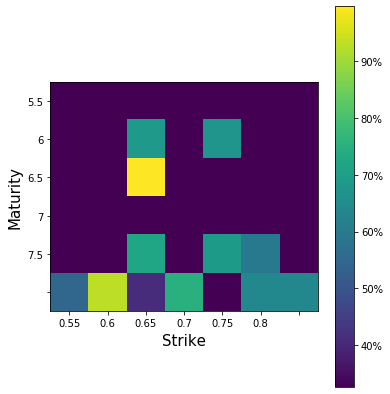

In [308]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


err = np.mean((100*np.abs((theta_true-Theta)/theta_true)),axis=2)
#print("Relative error in percent: ",err)
plt.figure(1,figsize=(len(T),len(K)))
ax=plt.subplot(1,1,1)
plt.imshow(err.reshape(len(T),len(K)))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticklabels(K)
ax.set_yticklabels(T)

plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)


plt.show()

In [309]:
print(Theta)

[[[ 1.5         1.5         0.5         0.5       ]
  [ 1.5         1.5         0.5         0.5       ]
  [ 1.5         1.5         0.5         0.5       ]
  [ 1.5         1.5         0.5         0.5       ]
  [ 1.5         1.5         0.5         0.5       ]
  [ 1.5         1.5         0.5         0.5       ]
  [ 1.5         1.5         0.5         0.5       ]]

 [[ 1.5         1.5         0.5         0.5       ]
  [ 1.5         1.5         0.5         0.5       ]
  [ 1.68298126  1.19503123  0.19503123  0.80496877]
  [ 1.5         1.5         0.5         0.5       ]
  [ 1.35444436  1.64555564  0.1         0.93666688]
  [ 1.5         1.5         0.5         0.5       ]
  [ 1.5         1.5         0.5         0.5       ]]

 [[ 1.5         1.5         0.5         0.5       ]
  [ 1.5         1.5         0.5         0.5       ]
  [ 2.          3.57415811  1.65438261  0.99      ]
  [ 1.5         1.5         0.5         0.5       ]
  [ 1.5         1.5         0.5         0.5       ]
  [ 1.5 

[1. 1. 1.]
